In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import proplot as pplt
import pycountry

In [2]:
start_year = 1990
end_year = 2019

In [3]:
column_to_label = {
    "Year": "Year",
    "Code": "Country ISO-3 Code",
    "Country": "Country",
    "Research_count": "Number of Research Papers",
    "tas": "Temperature (Celsius)",
    "tasmax": "Maximum Temperature (Celsius)",
    "tasmin": "Minimum Temperature (Celsius)",
    "pr": "Precipitation (mm/day)",
    "Death_rate_from_household_air_pollution_per_100000": "Death Rate from Household Air Pollution (per 100,000 people)",
    "Death_rate_from_ambient_PM2.5_per_100000": "Death Rate from Ambient PM2.5 (per 100,000 people)",
    "Death_rate_from_air_pollution_per_100000": "Death Rate from Air Pollution (per 100,000 people)",
    "Death_rate_from_ambient_ozone_per_100000": "Death Rate from Ambient Ozone (per 100,000 people)",
    "PM2.5_annual_exposure": "PM2.5 Mean Annual Exposure (ug/m$^3$)",
    "Population": "Population",
    "DALYs": "Disability-Adjusted Life Years (per person)",
    # "PM2.5_population_exceeding_WHO_target_1": "Population exposed to PM2.5 levels exceeding WHO Interim Target-1 value (% of total)",
    # "PM2.5_population_exceeding_WHO_target_2": "Population exposed to PM2.5 levels exceeding WHO Interim Target-2 value (% of total)",
    # "PM2.5_population_exceeding_WHO_target_3": "Population exposed to PM2.5 levels exceeding WHO Interim Target-3 value (% of total)",
    "PM2.5_population_exceeding_WHO_target_1": "PM2.5_population_exceeding_WHO_target_1",
    "PM2.5_population_exceeding_WHO_target_2": "PM2.5_population_exceeding_WHO_target_2",
    "PM2.5_population_exceeding_WHO_target_3": "PM2.5_population_exceeding_WHO_target_3",
    "PM2.5_population_exceeding_WHO_guideline": "PM2.5_population_exceeding_WHO_guideline",
    "Share_deaths_air_pollution": "Share of Deaths from Air Pollution among All Risk Factors (%)",
    "GDP_per_capita": "GDP per capita, (constant 2015 US$)",
    "Climate_related_disasters_frequency": "Climate-related Disasters Frequency (count)",
    "Land_area": "Land Area (sq km$^2$)",
    "Sufficiency": "Research Attention Degree Index",
    "Sufficiency_standardized": "Research Attention Degree Index",
    "tas_trend": "Temperature Trend (Celsius/Year)",
    "tas_PM2d5_corr": "Temperature-PM2.5 Correlation",
    "PM2d5_trend": "PM2.5 Mean Annual Exposure Trend (ug/m$^3$/Year)",
    "pr_PM2d5_corr": "Precipitation-PM2.5 Correlation",
    "Population_d_Land_area": "Population Density (people/km$^2$)",
}

In [4]:
def cal_long_time_variable(data):
    all_country =  data["Code"].unique()
    for country in all_country:
        tmp = data[data["Code"]==country].copy()
        tmp = tmp.sort_values(by=['Year'])
        
        tas_trend = np.polyfit(tmp["Year"], tmp["tas"], 1)[0]
        PM2d5_trend = np.polyfit(tmp["Year"], tmp["PM2.5_annual_exposure"], 1)[0]
        tas_PM2d5_corr = tmp["tas"].corr(tmp["PM2.5_annual_exposure"])
        pr_PM2d5_corr = tmp["pr"].corr(tmp["PM2.5_annual_exposure"])

        data.loc[data["Code"]==country, "tas_trend"] = tas_trend
        data.loc[data["Code"]==country, "PM2d5_trend"] = PM2d5_trend
        data.loc[data["Code"]==country, "tas_PM2d5_corr"] = tas_PM2d5_corr
        data.loc[data["Code"]==country, "pr_PM2d5_corr"] = pr_PM2d5_corr
    return data

In [5]:
def prepare_data(data, type, all_year_param="weighted"):
    if type == "multi-year":
        pass
    if type == "all-year":
        if all_year_param == "weighted":
            sum_research_count_year = data.groupby(['Year']).sum()['Research_count']
            all_country =  data["Code"].unique()
            weighted_mean_data = pd.DataFrame()
            sum_research_count_year_weight = np.array(sum_research_count_year) / np.sum(sum_research_count_year)
            for country in all_country:
                tmp = data[data["Code"]==country].copy()
                tmp = tmp.sort_values(by=['Year'])
                numeric_columns = tmp.select_dtypes(include=np.number).columns
                tmp[numeric_columns] = tmp[numeric_columns].mul(sum_research_count_year_weight, axis=0)
                tmp = tmp.sum(numeric_only=True)
                tmp["Code"] = country
                tmp = pd.DataFrame(tmp).T
                weighted_mean_data = pd.concat([weighted_mean_data, pd.DataFrame(tmp)], axis=0)
            all_year_data = weighted_mean_data
            all_year_data = all_year_data.drop(columns=['Year'])
            country_research_count_all = data.groupby(['Code']).sum()['Research_count']
            all_year_data.loc[:, "Research_count"] = np.array(country_research_count_all)
            data = all_year_data
        if all_year_param == "mean":
            all_year_data = data.groupby(['Code']).mean()
            all_year_data = all_year_data.drop(columns=['Year'])
            country_research_count_all = data.groupby(['Code']).sum()['Research_count']
            all_year_data.loc[:, "Research_count"] = np.array(country_research_count_all)
            all_year_data = all_year_data.reset_index()
            data = all_year_data
    return data

In [6]:
def cal_sufficiency_coef(data, param, type):
    data["Population_x_Land_area"] = data["Population"] * data["Land_area"]
    data["Population_d_Land_area"] = data["Population"] / data["Land_area"]
    if type == "multi-year":
        sum_research_count_year = data.groupby(['Year']).sum()['Research_count']
        sum_population_year = data.groupby(['Year']).sum()['Population']
        sum_land_area_year = data.groupby(['Year']).sum()['Land_area']
        sum_population_x_land_area_year = data.groupby(['Year']).sum()['Population_x_Land_area']
        sum_population_d_land_area_year = data.groupby(['Year']).sum()['Population_d_Land_area']
    if type == "all-year":
        sum_research_count_year = data['Research_count'].sum()
        sum_population_year = data['Population'].sum()
        sum_land_area_year = data['Land_area'].sum()
        sum_population_x_land_area_year = data['Population_x_Land_area'].sum()
        sum_population_d_land_area_year = data['Population_d_Land_area'].sum()
    if param == "population":
        sufficiency_coef = sum_research_count_year * (10**9) / (sum_population_year)
    if param == "population_x_land_area":
        sufficiency_coef = sum_research_count_year * (10**17) / (sum_population_x_land_area_year)
    if param == "population_d_land_area":
        sufficiency_coef = sum_research_count_year * (10) / (sum_population_d_land_area_year)
    if param == "land_area":
        sufficiency_coef = sum_research_count_year * (10**8) / (sum_land_area_year)
    if type == "multi-year":
        data["Sufficiency_coef"] = data["Year"].apply(lambda x: sufficiency_coef[x])
    if type == "all-year":
        data["Sufficiency_coef"] = sufficiency_coef
    if param == "population":
        data["Research_need"] = data["Sufficiency_coef"] * data["Population"] / (10**9)
    if param == "population_x_land_area":
        data["Research_need"] = data["Sufficiency_coef"] * data["Population_x_Land_area"] / (10**17)
    if param == "population_d_land_area":
        data["Research_need"] = data["Sufficiency_coef"] * data["Population_d_Land_area"] / (10)
    if param == "land_area":
        data["Research_need"] = data["Sufficiency_coef"] * data["Land_area"] / (10**8)
    data["Sufficiency"] = data["Research_count"] - data["Research_need"]
    return data, sum_research_count_year

In [7]:
def cal_standardized_sufficiency(data, param, type):
    if param == "pct":
        if type == "multi-year":
            for year in range(start_year, end_year+1):
                tmp = data[data["Year"]==year].copy()
                tmp.loc[tmp["Sufficiency"]>0, "Sufficiency_standardized"] = tmp[tmp["Sufficiency"]>0]["Sufficiency"] / tmp[tmp["Sufficiency"]>0]["Sufficiency"].max()
                tmp.loc[tmp["Sufficiency"]<=0, "Sufficiency_standardized"] = -1 * (tmp[tmp["Sufficiency"]<=0]["Sufficiency"] / tmp[tmp["Sufficiency"]<=0]["Sufficiency"].min())
                data.loc[data["Year"]==year, "Sufficiency_standardized"] = tmp["Sufficiency_standardized"]
        if type == "all-year":
            data.loc[data["Sufficiency"]>0, "Sufficiency_standardized"] = data[data["Sufficiency"]>0]["Sufficiency"] / data[data["Sufficiency"]>0]["Sufficiency"].max()
            data.loc[data["Sufficiency"]<=0, "Sufficiency_standardized"] = -1 * (data[data["Sufficiency"]<=0]["Sufficiency"] / data[data["Sufficiency"]<=0]["Sufficiency"].min())
    if param == "1/rank":
        if type == "multi-year":
            for year in range(start_year, end_year+1):
                tmp = data[data["Year"]==year].copy()
                tmp.loc[tmp["Sufficiency"]>0, "Sufficiency_standardized"] = tmp[tmp["Sufficiency"]>0]["Sufficiency"].rank(pct=True)
                tmp.loc[tmp["Sufficiency"]<=0, "Sufficiency_standardized"] = -1 * (tmp[tmp["Sufficiency"]<=0]["Sufficiency"].rank(pct=True, ascending=False))
                data.loc[data["Year"]==year, "Sufficiency_standardized"] = tmp["Sufficiency_standardized"]
        if type == "all-year":
            data.loc[data["Sufficiency"]>0, "Sufficiency_standardized"] = data[data["Sufficiency"]>0]["Sufficiency"].rank(pct=True)
            data.loc[data["Sufficiency"]<=0, "Sufficiency_standardized"] = -1 * (data[data["Sufficiency"]<=0]["Sufficiency"].rank(pct=True, ascending=False))
    return data

In [8]:
def draw_year_sufficiency(data, param, top=5):
    # Top max mean Sufficiency_standardized
    max_country = data.groupby(['Code']).mean().sort_values(by=['Sufficiency_standardized'], ascending=False).head(top).index.to_list()

    # Top min mean Sufficiency_standardized
    min_country = data.groupby(['Code']).mean().sort_values(by=['Sufficiency_standardized'], ascending=False).tail(top).index.to_list()

    draw_country = max_country + min_country

    fig = pplt.figure()
    axs = fig.subplots(nrows=2, ncols=top)
    for i, country in enumerate(draw_country):
        axs[i].plot(data=data[data["Code"]==country], x=range(start_year, end_year+1), y=param)
        axs[i].format(xlabel='Year', ylabel=column_to_label[param], 
            title=pycountry.countries.get(alpha_3=country).name+" "+str(int(data[data["Code"]==country]["Research_count"].sum())))

In [9]:
def process_before_draw(data, type, sum_research_count_year=None):
    if type == "multi-year":
        # 计算每个国家各参数的多年平均值，用这一年的研究总数加权。
        all_country =  data["Code"].unique()
        weighted_mean_data = pd.DataFrame()
        sum_research_count_year_weight = np.array(sum_research_count_year) / np.sum(sum_research_count_year)
        for country in all_country:
            tmp = data[data["Code"]==country].copy()
            tmp = tmp.sort_values(by=['Year'])
            numeric_columns = tmp.select_dtypes(include=np.number).columns
            tmp[numeric_columns] = tmp[numeric_columns].mul(sum_research_count_year_weight, axis=0)
            tmp = tmp.sum(numeric_only=True)
            tmp["Code"] = country
            tmp = pd.DataFrame(tmp).T
            weighted_mean_data = pd.concat([weighted_mean_data, pd.DataFrame(tmp)], axis=0)
        data = weighted_mean_data
        data = data.drop(columns=['Year'])
    if type == "all-year":
        pass
    data.reset_index(drop=True, inplace=True)
    data["Population"] = data["Population"].astype(np.float64)
    data["Land_area"] = data["Land_area"].astype(np.float64)
    data["Research_need"] = data["Research_need"].astype(np.float64)
    data["Sufficiency_standardized"] = data["Sufficiency_standardized"].astype(np.float64)
    data["Research_count"] = data["Research_count"].astype(np.float64)
    return data

/tmp/ipykernel_2928318/3608304675.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/tmp/ipykernel_2928318/3608304675.py:18: ProplotWarning: 'subplot_kw' is not necessary in proplot. Pass the parameters as keyword arguments instead.
  axs = fig.subplots(nrows=1, ncols=1, subplot_kw={'projection': 'robin'})
/home/lyx/anaconda3/envs/llm-cli-air-review/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


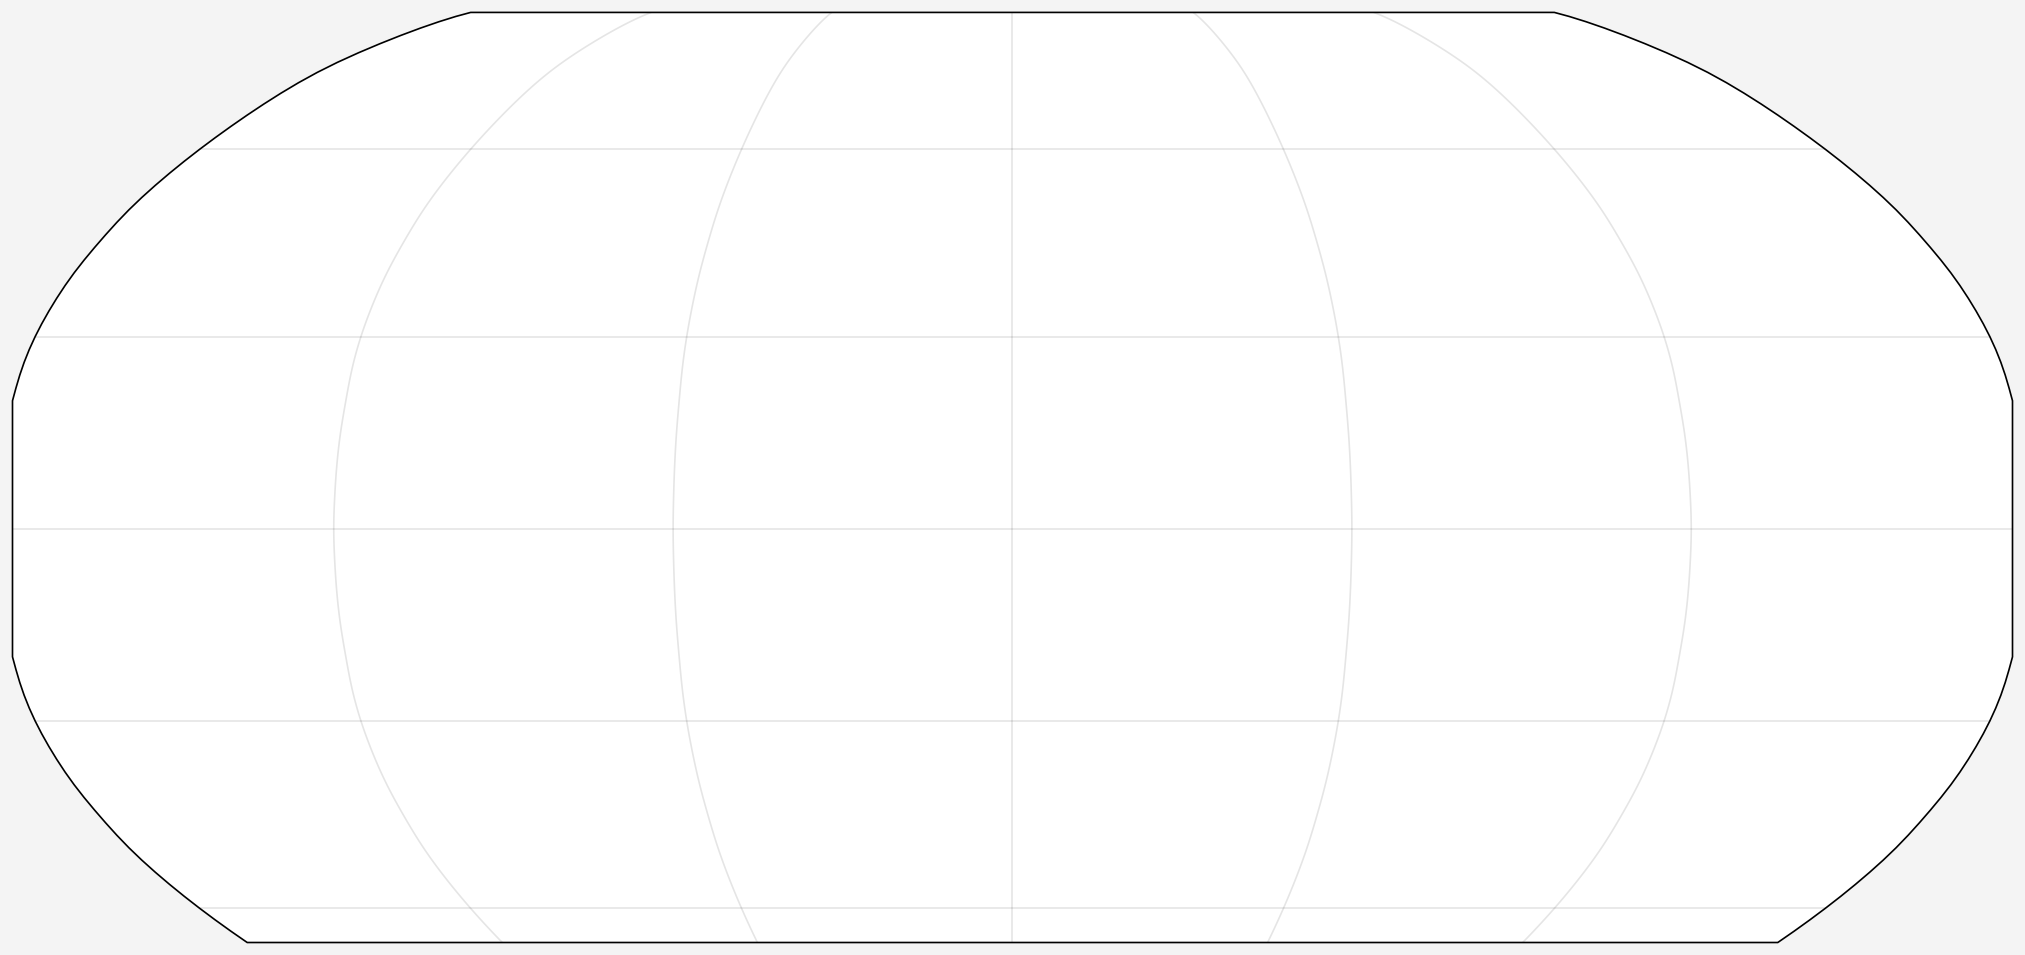

In [10]:
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world[world["iso_a3"]=="-99"]
# set iso_a3 for Norway, France, N.Cyprus, Somaliland, Kosovo
world.loc[world["name"]=="Norway", "iso_a3"] = pycountry.countries.get(name="Norway").alpha_3
world.loc[world["name"]=="France", "iso_a3"] = pycountry.countries.get(name="France").alpha_3
world.loc[world["name"]=="N. Cyprus", "iso_a3"] = pycountry.countries.get(name="Cyprus").alpha_3
world.loc[world["name"]=="Somaliland", "iso_a3"] = pycountry.countries.get(name="Somalia").alpha_3

# Income groups hatch
# Income classification: Code, Country, Classification
income_classification = pd.read_csv("../Temperature_Impact/Income_Classification_2021.csv")
income_classification = income_classification.drop(columns=["Country"])

# 单独画一下income group hatch并保存
merged = world
fig = pplt.figure(refwidth=10)
axs = fig.subplots(nrows=1, ncols=1, subplot_kw={'projection': 'robin'})
merged.to_crs('+proj=robin', inplace=True)
merged = merged.merge(income_classification, left_on='iso_a3', right_on='Code', how='left')
hatch_patterns = {"H": "///", "UM": "---", "LM": "...", "L": "+++"}
for income_level, hatch in hatch_patterns.items():
    merged.loc[merged["Classification"]==income_level, "hatch"] = hatch
merged.loc[merged["iso_a3"]=="TWN", "hatch"] = merged.loc[merged["iso_a3"]=="CHN", "hatch"].values[0]
for i in merged.index:
    if merged.loc[i, "hatch"] is not None and not pd.isnull(merged.loc[i, "hatch"]):
        merged.loc[[i], :].plot(ax=axs[0], color="none", ec="white", linewidth=0.0001, hatch=merged.loc[i, "hatch"])
axs[0].set_extent([-180, 180, -66, 90])
fig.save("income_hatch.png", dpi=1000, transparent=True)

def draw_main_figures(data, param):
    merged = world.merge(data, left_on='iso_a3', right_on='Code', how='left')
    merged.loc[merged["iso_a3"]=="TWN", param] = data[data["Code"]=="CHN"][param].values[0]

    fig = pplt.figure(refwidth=10)
    axs = fig.subplots(nrows=1, ncols=1, subplot_kw={'projection': 'robin'})
    merged.to_crs('+proj=robin', inplace=True)
    m = merged.plot(column=param, ax=axs[0], cmap='NegPos', vmin=-1, vmax=1, ec="lightgrey", missing_kwds={'color': 'lightgrey'})

    sm = plt.cm.ScalarMappable(cmap='NegPos', norm=plt.Normalize(vmin=-1, vmax=1))
    sm._A = []

    # Draw Income Hatches
    # Merge Income Classification
    merged = merged.merge(income_classification, left_on='iso_a3', right_on='Code', how='left')
    # Hatch countries differently based on income levels: H, UM, LM, L
    hatch_patterns = {"H": "///", "UM": "---", "LM": "...", "L": "+++"}
    for income_level, hatch in hatch_patterns.items():
        merged.loc[merged["Classification"]==income_level, "hatch"] = hatch
    merged.loc[merged["iso_a3"]=="TWN", "hatch"] = merged.loc[merged["iso_a3"]=="CHN", "hatch"].values[0]
    # Plot the hatched countries
    for i in merged.index:
        if merged.loc[i, "hatch"] is not None and not pd.isnull(merged.loc[i, "hatch"]):
            merged.loc[[i], :].plot(ax=axs[0], color="none", ec="white", linewidth=0.0001, hatch=merged.loc[i, "hatch"])
    # Edge color
    # m = merged.plot(color="none", ax=axs[0], ec="lightgrey")

    # axs[0].format(title=column_to_label['Sufficiency_standardized'])
    # axs[0].format(ylim=(-66,90))
    axs[0].set_extent([-180, 180, -66, 90])
    print(axs[0])
    axs[0].colorbar(sm, label=column_to_label[param])
    fig.save("sufficiency_map.svg")
    fig.save("sufficiency_map.png", dpi=1000, transparent=True)
    fig.show()

    # x_param = data.columns.to_list()
    # x_param = set(x_param) - set(['Code', 'Research_count', 'Population', 'Land_area', 'Population_d_Land_area', 'Population_x_Land_area', 'Sufficiency_coef', 'Research_need', 'Sufficiency', 'Sufficiency_standardized', 'Country'])
    # x_param = list(x_param)
    # x_param = sorted(x_param)
    x_param = ["GDP_per_capita", "tas", "pr", 
               "PM2.5_annual_exposure", "Death_rate_from_air_pollution_per_100000", "Share_deaths_air_pollution",
               "PM2d5_trend", "tas_PM2d5_corr", "pr_PM2d5_corr"]
    print(x_param)

    fig = pplt.figure(sharex=False)
    axs = fig.subplots(ncols=3, nrows=3)
    y = param
    for i, x in enumerate(x_param):
        x_array = np.array(data[x], dtype=np.float64)
        y_array = np.array(data[y], dtype=np.float64)
        axs[i].axhline(y=0, color='grey', linestyle='--')
        scatter = axs[i].scatter(x_array, y_array,
            s=((data["Population"]/15285)**0.5), smax=305, color=data["Land_area"], ec='grey', alpha=0.7)
        # 将R2值放在图上
        mask = ~np.isnan(x_array) & ~np.isnan(y_array)
        r = np.corrcoef(x_array[mask], y_array[mask])[0, 1]
        # axs[i].text(0.32, 0.95, f"r={r:.2f}, R2={r**2:.2f}", transform=axs[i].transAxes)
        axs[i].format(xlabel=column_to_label[x], ylabel=column_to_label[y])
        # R2, 2 should be subscript
        axs[i].format(title=f"r={r:.2f}, R$^2$={r**2:.2f}")
        if x == "GDP_per_capita":
            axs[i].format(xscale='log')
        # Point out China, India, USA
        for anno_country in ["CHN", "IND", "USA"]:
            axs[i].text(data[data["Code"]==anno_country][x].values[0], data[data["Code"]==anno_country][y].values[0], anno_country, fontsize=8)

    fig.legend(*scatter.legend_elements(prop='sizes', func=lambda x: (x**2)*15285, num=6), title="Population (10^9 people)", loc='b', ncols=6, frame=False)
    fig.legend(*scatter.legend_elements(prop='colors', num=5), title="Land Area (10^7 sq km$^2$)", loc='b', ncols=6, frame=False)
    fig.save("sufficiency_scatter.svg")
    fig.show()

In [11]:
type = "all-year"
sufficiency_coef_param = "population"
standardized_sufficiency_param = "rank"
draw_param = "Sufficiency_standardized"

In [12]:
data = pd.read_csv('Implication_data.csv')

In [13]:
data

,Year,Code,Research_count,tas,tasmax,tasmin,pr,Death_rate_from_household_air_pollution_per_100000,Death_rate_from_ambient_PM2.5_per_100000,Death_rate_from_air_pollution_per_100000,...,DALYs,PM2.5_population_exceeding_WHO_target_1,PM2.5_population_exceeding_WHO_target_2,PM2.5_population_exceeding_WHO_target_3,PM2.5_population_exceeding_WHO_guideline,Share_deaths_air_pollution,Climate_related_disasters_frequency,Land_area,Country,GDP_per_capita
0,1990,AFG,0.0,13.152500,20.533333,5.806667,30.139167,370.05,30.82,402.18,...,1986290.42,99.958321,100.000000,100.0,100.0,21.33,1.0,652230.0,Afghanistan,359.766343
1,1991,AFG,0.0,12.565000,19.603333,5.564167,35.847500,358.98,29.83,390.09,...,2069430.00,99.958589,100.000000,100.0,100.0,21.01,4.0,652230.0,Afghanistan,359.766343
2,1992,AFG,0.0,12.225000,19.341667,5.142500,33.663333,352.77,29.20,383.20,...,2298508.31,99.958858,100.000000,100.0,100.0,21.19,2.0,652230.0,Afghanistan,359.766343
3,1993,AFG,0.0,12.667500,19.737500,5.630833,27.560000,357.06,29.43,387.70,...,2555748.30,99.959126,100.000000,100.0,100.0,21.37,3.0,652230.0,Afghanistan,359.766343
4,1994,AFG,0.0,12.766667,20.032500,5.535833,28.170833,362.97,29.81,394.02,...,2707119.92,99.959395,100.000000,100.0,100.0,21.09,0.0,652230.0,Afghanistan,359.766343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025,2015,ZWE,0.0,22.319167,29.511667,15.183333,37.790833,143.48,39.00,183.04,...,653410.93,0.000000,7.219464,100.0,100.0,10.98,1.0,386850.0,Zimbabwe,1410.329174
6026,2016,ZWE,0.0,22.268333,29.186667,15.394167,44.200833,140.64,37.59,179.06,...,641920.17,0.000000,8.708582,100.0,100.0,11.02,1.0,386850.0,Zimbabwe,1393.717011
6027,2017,ZWE,0.0,21.728333,28.365000,15.136667,75.289167,137.45,35.81,174.05,...,625386.35,0.000000,8.066919,100.0,100.0,11.00,2.0,386850.0,Zimbabwe,1421.240770
6028,2018,ZWE,0.0,22.108333,28.941667,15.325833,52.919167,133.92,34.93,169.53,...,609545.33,0.000000,8.066919,100.0,100.0,11.06,0.0,386850.0,Zimbabwe,1462.590280


In [14]:
data.dtypes

Year                                                    int64
Code                                                   object
Research_count                                        float64
tas                                                   float64
tasmax                                                float64
tasmin                                                float64
pr                                                    float64
Death_rate_from_household_air_pollution_per_100000    float64
Death_rate_from_ambient_PM2.5_per_100000              float64
Death_rate_from_air_pollution_per_100000              float64
Death_rate_from_ambient_ozone_per_100000              float64
PM2.5_annual_exposure                                 float64
Population                                            float64
DALYs                                                 float64
PM2.5_population_exceeding_WHO_target_1               float64
PM2.5_population_exceeding_WHO_target_2               float64
PM2.5_po

In [14]:
data = cal_long_time_variable(data)

In [15]:
data["DALYs"] /= data["Population"]

In [16]:
data = prepare_data(data, type=type, all_year_param="weighted")

In [17]:
data, sum_research_count_year = cal_sufficiency_coef(data, sufficiency_coef_param, type)

In [18]:
data = cal_standardized_sufficiency(data, standardized_sufficiency_param, type)

In [19]:
if type == "multi-year":
    draw_year_sufficiency(data, draw_param, top=5)

In [ ]:
data = process_before_draw(data, type, sum_research_count_year)

In [ ]:
data.sort_values(by=draw_param, ascending=False, inplace=False)

In [ ]:
draw_main_figures(data, "Sufficiency_standardized")

all-year population 1/rank Sufficiency_standardized


/tmp/ipykernel_2928318/3608304675.py:36: ProplotWarning: 'subplot_kw' is not necessary in proplot. Pass the parameters as keyword arguments instead.
  axs = fig.subplots(nrows=1, ncols=1, subplot_kw={'projection': 'robin'})
/home/lyx/anaconda3/envs/llm-cli-air-review/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


GeoAxesSubplot(index=(0, 0), number=1, backend='cartopy')
['GDP_per_capita', 'tas', 'pr', 'PM2.5_annual_exposure', 'Death_rate_from_air_pollution_per_100000', 'Share_deaths_air_pollution', 'PM2d5_trend', 'tas_PM2d5_corr', 'pr_PM2d5_corr']


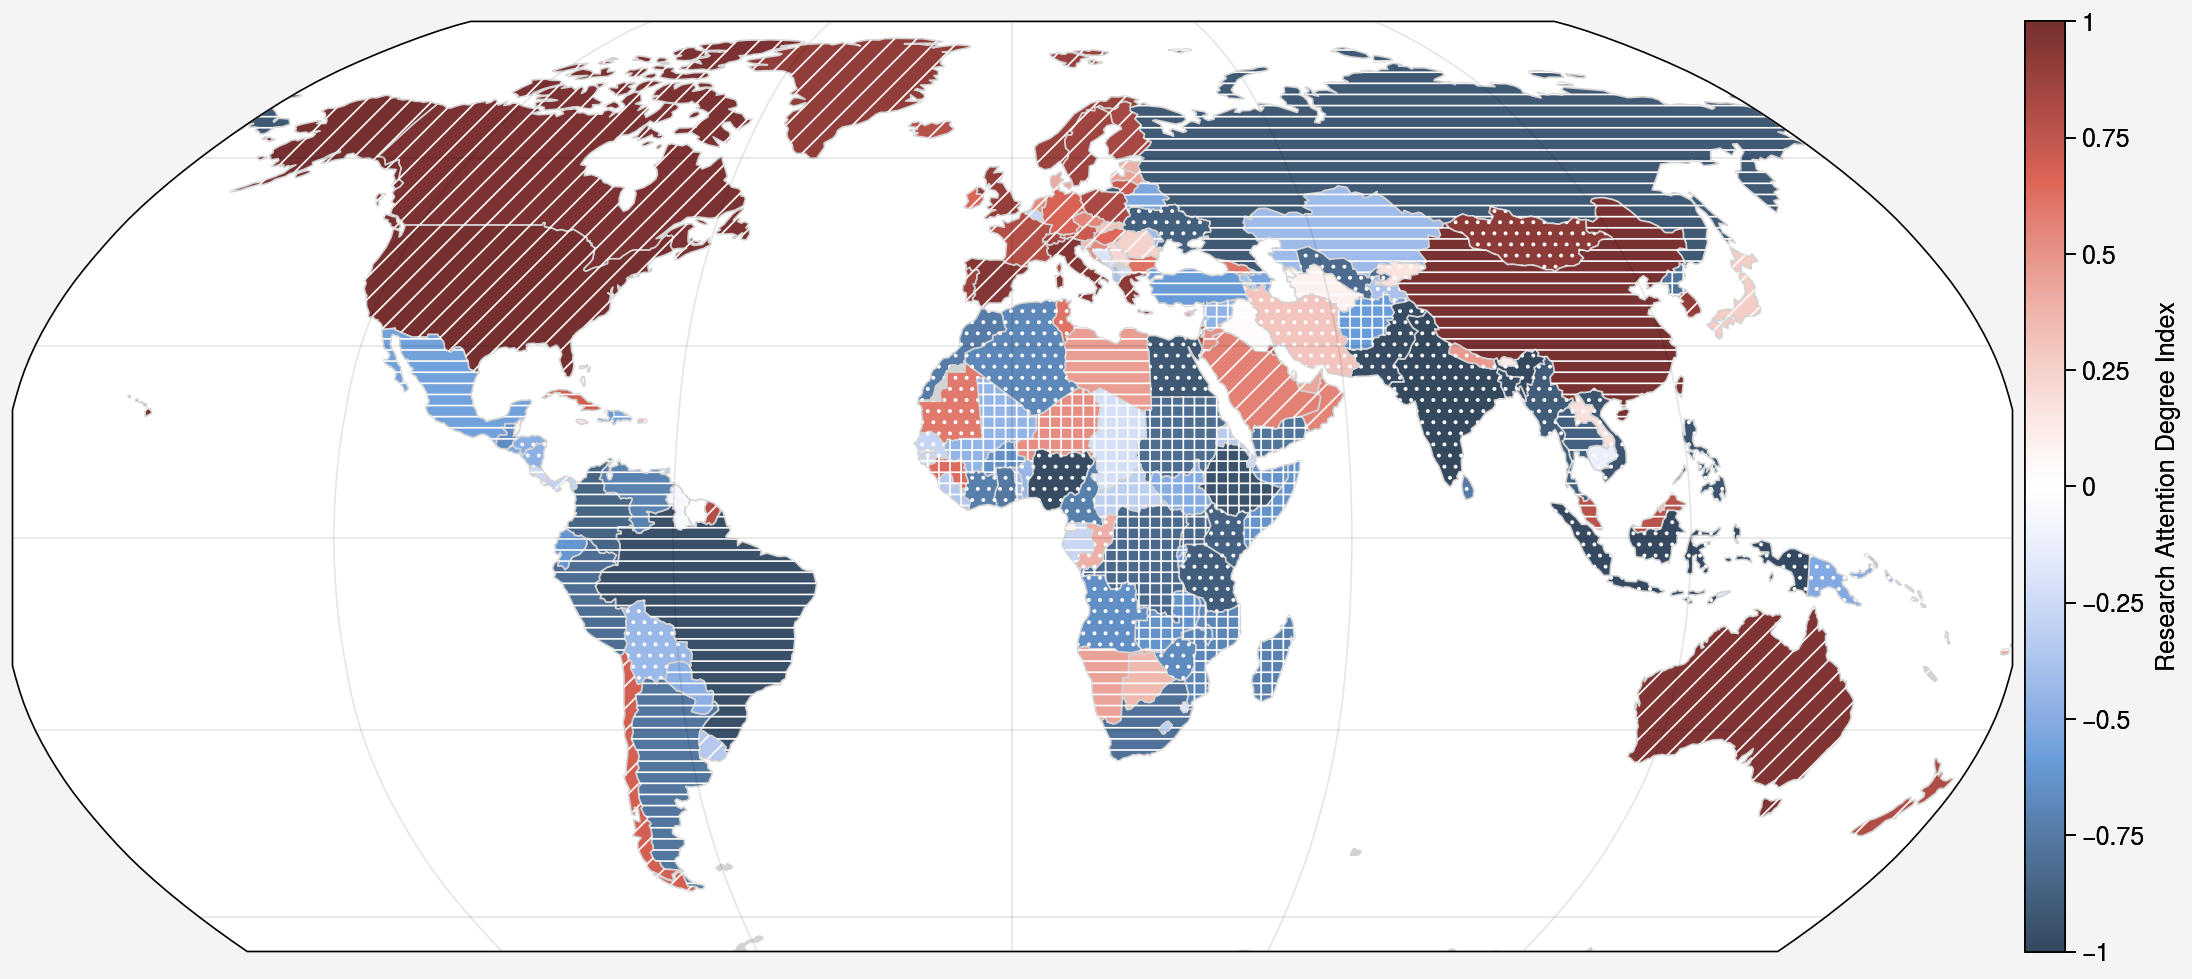

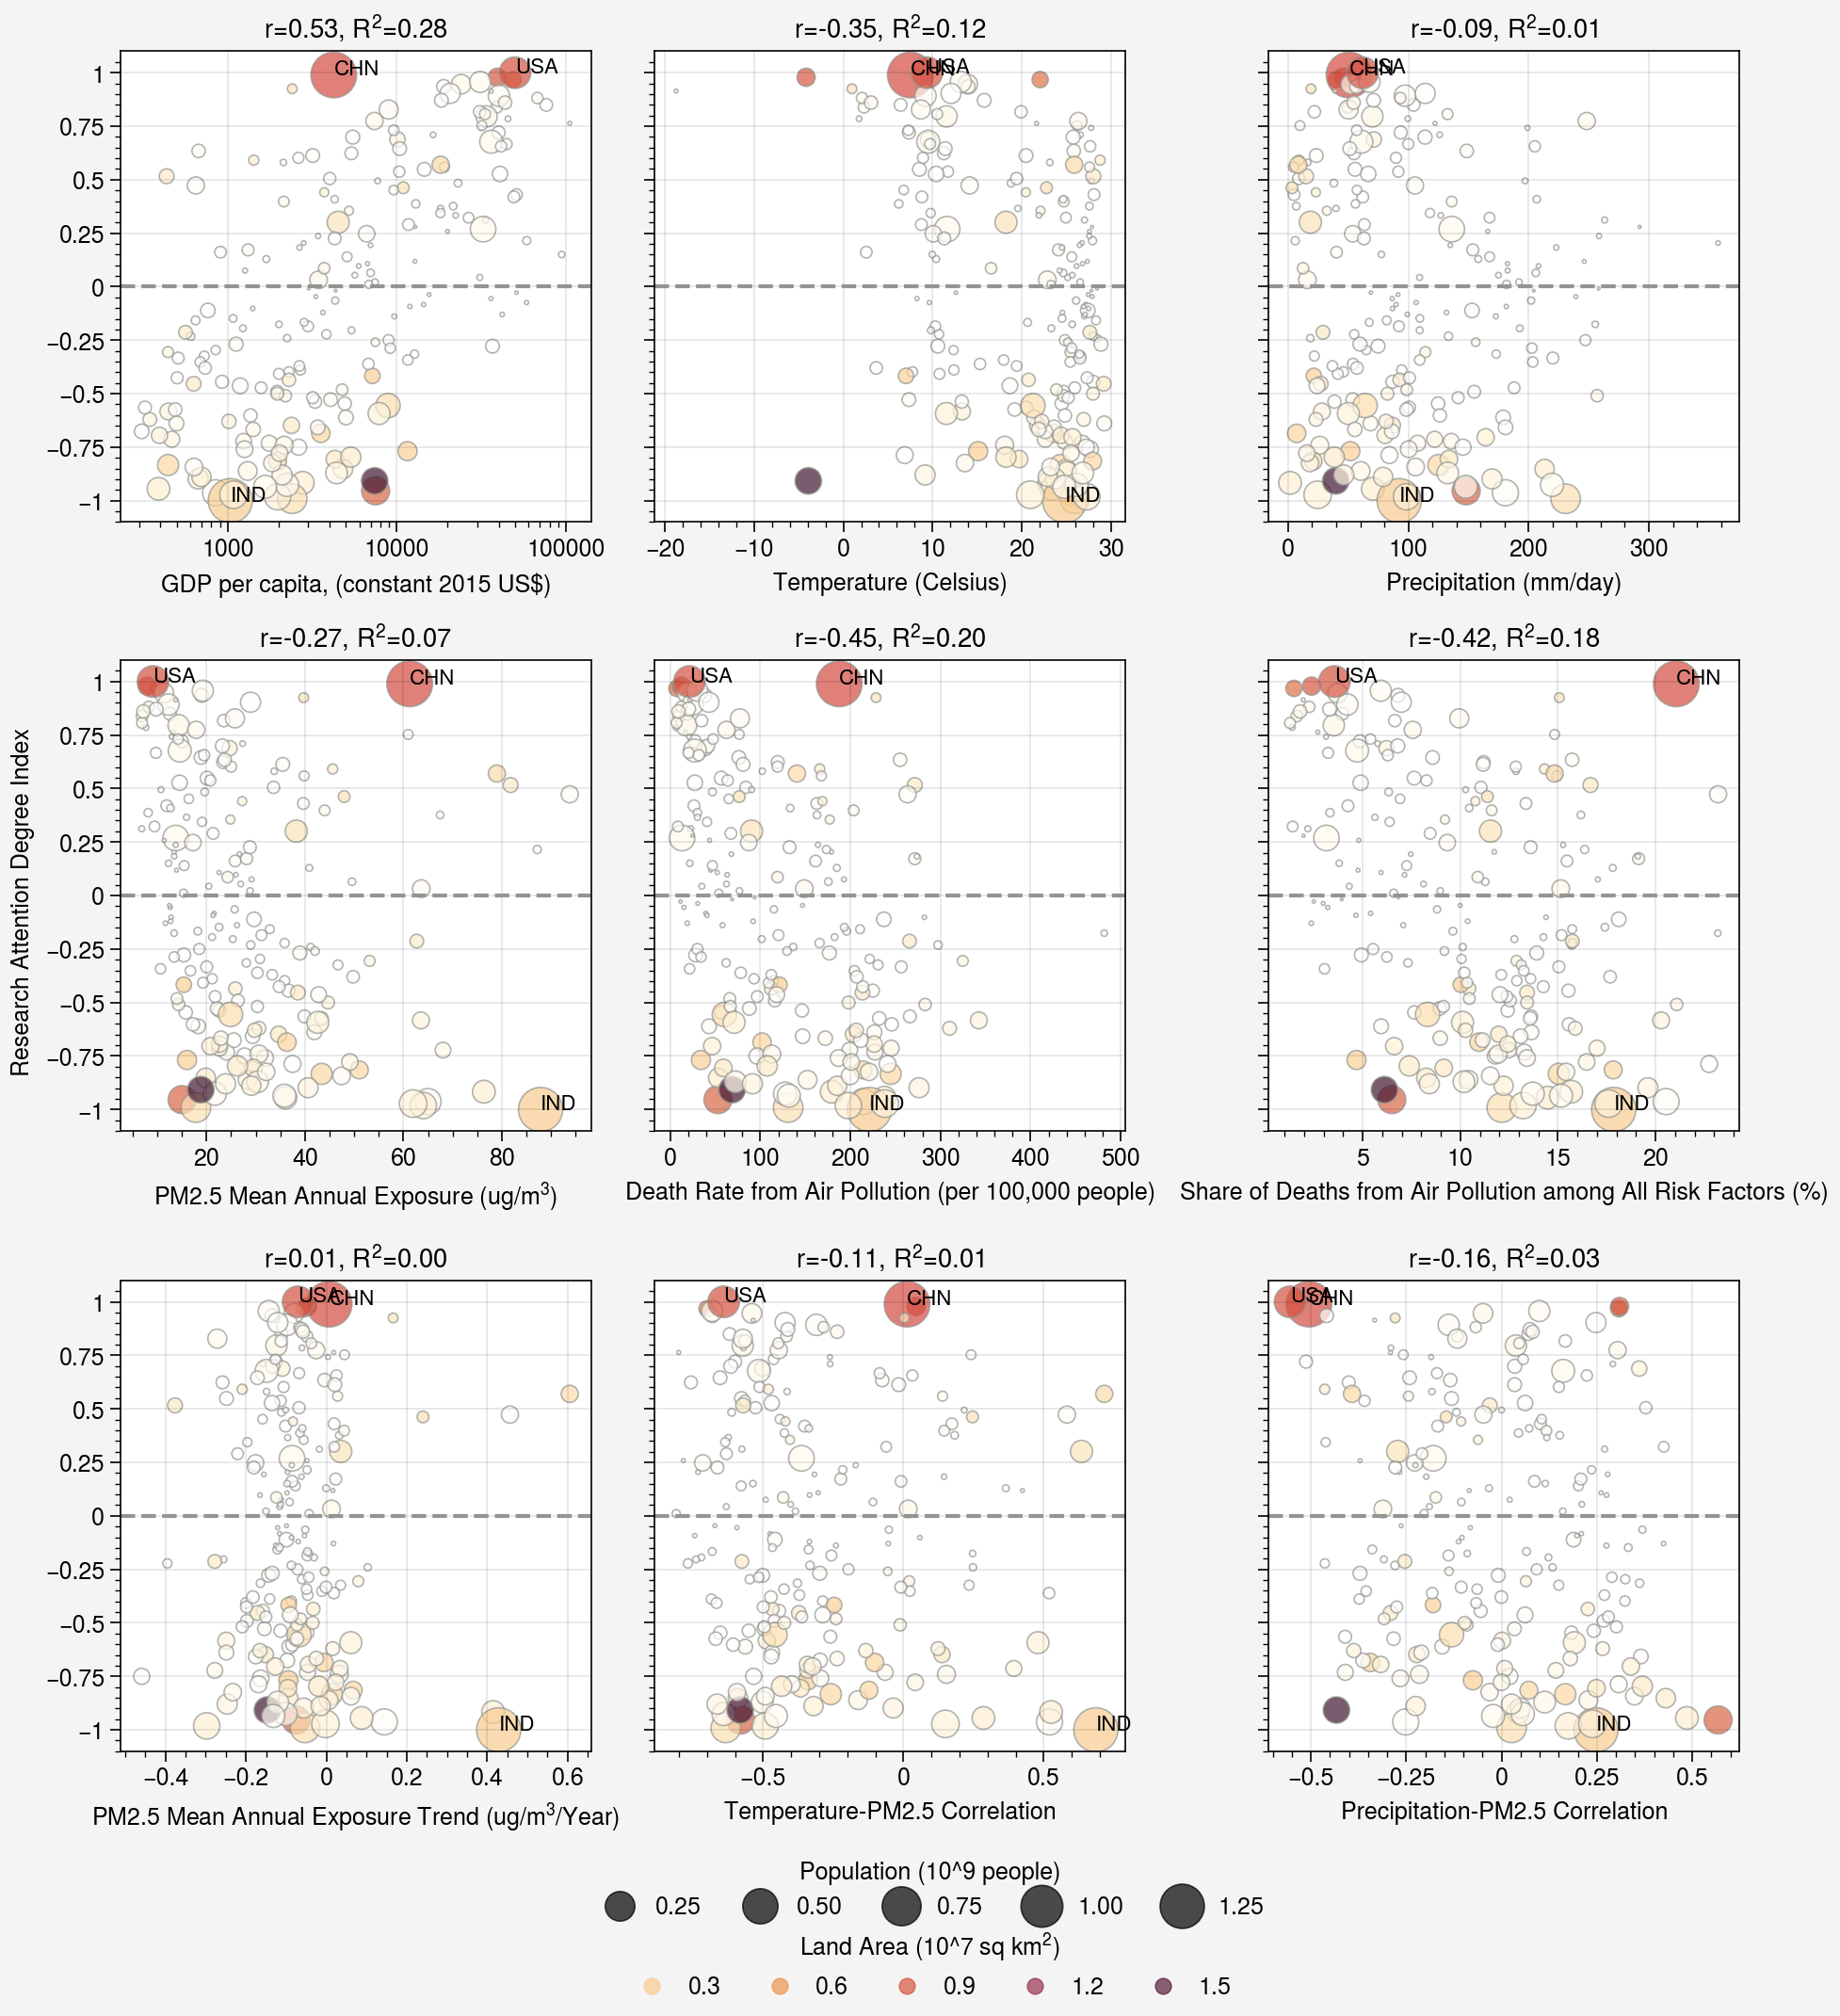

In [11]:
type = "all-year"
sufficiency_coef_param = "population"
standardized_sufficiency_param = "1/rank"
draw_param = "Sufficiency_standardized"
print(type, sufficiency_coef_param, standardized_sufficiency_param, draw_param)
data = pd.read_csv('Implication_data.csv')
data = cal_long_time_variable(data)
data["DALYs"] /= data["Population"]
data = data.drop(columns=['Country']) # 新加的
data = prepare_data(data, type=type, all_year_param="mean")
data, sum_research_count_year = cal_sufficiency_coef(data, sufficiency_coef_param, type)
data = cal_standardized_sufficiency(data, standardized_sufficiency_param, type)
if type == "multi-year":
    draw_year_sufficiency(data, draw_param, top=5)
data = process_before_draw(data, type, sum_research_count_year)
draw_main_figures(data, "Sufficiency_standardized")

In [ ]:
type = "all-year"
sufficiency_coef_param = "population"
standardized_sufficiency_param = "1/rank"
draw_param = "Sufficiency_standardized"

for type in ["all-year"]:
    for sufficiency_coef_param in ["population", "land_area", "population_x_land_area"]:
        for standardized_sufficiency_param in ["pct", "1/rank"]:
            draw_param = "Sufficiency_standardized"
            print(type, sufficiency_coef_param, standardized_sufficiency_param, draw_param)
            data = pd.read_csv('Implication_data.csv')
            data = cal_long_time_variable(data)
            data["DALYs"] /= data["Population"]
            data = prepare_data(data, type=type, all_year_param="mean")
            data, sum_research_count_year = cal_sufficiency_coef(data, sufficiency_coef_param, type)
            data = cal_standardized_sufficiency(data, standardized_sufficiency_param, type)
            if type == "multi-year":
                draw_year_sufficiency(data, draw_param, top=5)
            data = process_before_draw(data, type, sum_research_count_year)
            draw_main_figures(data, "Sufficiency_standardized")